# David Fleming 
# HW 1 Question 6: Lasso Regression
# CSE 546 Machine Learning
# Prof. Kakade

In [1]:
#Imports
%matplotlib inline

import scipy.sparse as sp
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from __future__ import division

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)
plt.rcParams['font.family'] = 'serif' 
plt.rcParams['font.size'] = 20.0

# Scipy sparse matrix example from the ghost of CSE 546 past

In [2]:
####
# This is a quick walkthrough to help you understand the operations in scipy.sparse
####

# construct a sparse array, here we simply construct it from dense array
A = np.arange(12).reshape(3,4)
print A
X = sp.csc_matrix(A)

w = np.ones(4)
print
print X.shape, w.shape

#  matrix vector multiplication
y = X.dot(w)
print
print y

#
# dot product between i-th column of X and g
#
i = 0
g = np.ones(3)
# r1 = dot(X[:,i], g), because X takes matrix syntax, we need to do it in this way
r1 = X[:,i].T.dot(g)
print
print r1
#
# This is how you can get dot(X[:,i], X[:,i]) in csc_matix
#
r2 = X[:,i].T.dot(X[:,i])[0,0]
print
print r2

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

(3, 4) (4,)

[  6.  22.  38.]

[ 12.]

80


# Define a function to generate data from a linear model with Gaussian noise as described by Question 6.3.

In [3]:
def generate_norm_data(n,k,d,sigma=1):
    """
    Generates independent data pairs (x_i,y_i) according to the following model:
    
    yi = w*_0 + w*_1x_i_1 + w*2 x_i_2 + ... w*k x_i_k + eps_i
    
    for eps_i = Gaussian noise of the form N(0,sigma^2)
    and each element of X (shape N x d) is from N(0,1)
    
    Parameters
    ----------
    n : int
        Number of samples
    k : int
        k < d number of features for dimensions d
    d : int
        number of dimensions
    sigma : float
        Gaussian error standard deviation
        
    Returns
    -------
    w : vector
        true weight vector
    X : n x d matrix
        data matrix
    y : n x 1 vector
    """
    assert(k < d), "k < d must hold for k: %lf, d: %lf" % (k,d)
    
    #Create w vector
    #Let w0 = 0 and create a w∗ by setting the first k elements to ±10 
    #(choose any sign pattern) and the remaining elements to 0
    w = np.zeros(d)
    for i in range(1,k+1):
        if i < k/2:
            w[i] = 10
        else:
            w[i] = -10
    
    #Generate n x d data matrix X for each element from N(0,1)
    X = sp.csc_matrix(np.random.randn(n, d))
    
    #Generate n x 1 array of Gaussian error samples from N(0,sigma^2)
    eps = np.random.randn(n)
    
    #Finally, generate a Gaussian noise vector eps with variance σ^2 and 
    #form y = Xw* + w*_0 + eps for w*_0 assumed to be 0
    y = X.dot(w) + eps
        
    return w, X, y

# Define a function to calculate the root mean square error.

In [4]:
def calc_RMSE(y,y_hat):
    """
    Compute the mean squared error of the prediction
    y_hat relative to the observed y
    
    Parameters
    ----------
    y : array (n x 1)
        observed
    y_hat : array (n x 1)
        predicted
    """
    assert(len(y) == len(y_hat))
    ret = 0.0
    for i in range(0,len(y)):
        ret += np.power(y_hat[i] - y[i],2.0)
    return np.sqrt(ret/len(y))

In [5]:
def check_solution(X,y,w_pred,w_0_pred,l):
    """
    See if the computed solution w_pred, w_0_pred for a given lambda l
    is correct.  That occurs when:
    
    test = 2X^T(Xw_pred + w_0_pred - y)
    test_j = -lambda*sign(w_pred_j) for each j that is nonzero
    Otherwise, each j value should be lesser in magnitude that lambda
    
    Parameters
    ----------
    X : n x d matrix of data
    y : N x 1 vector of response variables
    w_pred : predicted d dimensions weight vector
    w_0_pred : scalar offset term
    l : regularization tuning parameter
    
    Returns
    -------
    ans : bool
        whether or not the solution passes the test criteria
    """
    eps = 1.0e-8
    condition = False
    
    test = 2.0*X.T*(X.dot(w_pred) + w_0_pred - y)
    
    #Mask values corresponding to w_pred == 0
    mask = np.fabs(w_pred) < eps
    mask2 = np.fabs(test[mask]) < l
    mask = np.ones(len(w_pred))[mask]
            
    if np.array_equal(mask2,mask) and np.sum(mask) != len(w_pred):
        w_j = test[np.logical_not(mask)]
        if np.allclose(w_j,-l*np.sign(w_j),atol=1.0e-10, rtol=1.0e-1) and w_j != []:
            condition = True
        else:
            condition = False
    else:
        condition = False
    
    return condition

# Define a function to compute $\lambda_{max}$ where $\lambda_{max}$ is the smallest value  for which the solution w is entirely zero as described by Question 6.2.

In [6]:
def compute_max_lambda(X,y):
    """
    Compute the smallest lambda for which the solution w is entirely zero
    
    Parameters
    ----------
    X : n x d matrix of data (scipy sparse matrix)
    y : n x 1 vector of response variables
    
    Returns
    -------
    l : float
        Smallest value of lambda for which the solution w is entirely zero
    """
    y_mean = np.mean(y)
    arg = X.T.dot(y - y_mean)
    return 2.0*np.linalg.norm(arg,ord=np.inf)

# The function naive_lasso performs a lasso regression via coordinate descent described by algorithm one in Question 6.1.
This algorithm has been sped up by making use of numpy arrays for y and w and scipy sparse matricies for the data input matrix X.  For optimal performance, summations via for loops are avoided in favor up using vector/matrix multiplications using dot products and vector addition.  For code performance, see the cells below.

In [7]:
def naive_lasso(X,y,l=10,w=-999,w_0=-999):
    """
    Implimentation of the naive (un-optimized) lasso regression 
    algorithm.
    
    Parameters
    ----------
    X : n x d matrix of data
    X_i : the ith row of X
    y : N x 1 vector of response variables
    w : d dimensions weight vector (optional)
    w_0 : scalar offset term (optional)
    l : regularization tuning parameter
    
    All matrices X assumed to be sparse and of the form given by 
    scipy.sparse.csc matrix
    
    Algorithm 1: Coordinate Descent Algorithm for Lasso
    
    while not converged do:
        w_0 <- sum_i=1_N[y_i - sum_j[w_j X_ij]]/N
        for(k [1,d]) do:
            a_k <- 2 * sum_i=1_N[X_ik ^2]
            c_k <- 2 * sum_i=1_N[X_ik (y_i - (w_0 + sum_j!=k[w_j X_ij]))]
            w_k <- (c_k + lambda)/a_k if c_k < -lambda
                    0 if c_k is between [-lambda,lambda]
                    (c_k - lambda)/a_k if c_k > lambda
        end
    end

    Returns
    -------
    w : numpy array
        d x 1 weight vector
    w_0 : float
        offset
    y_hat : numpy array (n x 1)
        predictions
    """
    #Define values
    N = y.shape[0]
    d = X.shape[1]
    y = y.reshape(N,1)
    
    #If no initial conditions, assume Gaussian
    if not hasattr(w, "__len__") and w == -999:
        w = np.random.randn(d)
    if w_0 == -999:
        w_0 = np.random.randn(1)
    
    #Convergence condition
    eps = 1.0e-3
    w_old = np.zeros(w.shape).reshape(d,1)
    w_pred = np.copy(w).reshape(d,1)
    
    while(np.sqrt((w_pred - w_old).dot((w_pred - w_old).T)[0][0]) > eps):
        #Store for convergence test 
        w_old = np.copy(w_pred)
        
        #Compute w_0
        w_0 = np.sum(y)
        w_0 -= X.dot(w_pred).sum()
        w_0 /= N
            
        #Compute a_k: d x 1 summing over columns
        a = 2.0*np.asarray((X.power(2).sum(axis=0).T))
        c = np.zeros(d)
         
        for k in range(0,d):
            
            alpha = np.zeros((d,d))
            np.fill_diagonal(alpha, 1)
            alpha[k,k] = 0
            alpha = X.dot(alpha.dot(w_pred)) + w_0
            
            #Compute c: d x 1
            c[k] = 2.0*X[:,k].T.dot((y-alpha))
            
            """
            #Compute c_k: d x 1
            c_sum = 0.0
            for i in range(0,N):
                #Select not k columns
                ind = [x for x in range(0,d) if x != k]
                c_sum += X[i,k]*(y[i] - (X[i,ind].dot(w_pred[ind]) + w_0))
            c[k] = 2.0*c_sum
            """
            
            #Compute w_k
            if(c[k] < -l):
                w_pred[k] = (c[k] + l)/a[k]
            elif(c[k] >= -l and c[k] <= l):
                w_pred[k] = 0.0
            elif(c[k]  > l):
                w_pred[k] = (c[k] - l)/a[k]
            else:
                print "Error! Shouldn't ever happen."
        #end for
        #print w_pred
    #end while
    
    #Return as row array
    y_hat = np.zeros(y.shape)
    y_hat = X.dot(w_pred) + w_0
    return w_pred.T, w_0, y_hat

# The function lasso_reg_path solves multiple Lasso problems on a regularization path, starting at $\lambda_{max}$ and decreasing $\lambda$ by a constant ratio until few features are chosen correctly.  Each iteration stores informative data, such as correct non-zero features, RMSE, etc, for subsequent algorithm evalution.

In [90]:
def lasso_reg_path(X,y,w=-999,w_0=-999,scale=0.8,reg_type="naive",X_val=0,y_val=0):
    """
    Implimentation of the naive (un-optimized) lasso regression 
    algorithm.
    
    Parameters
    ----------
    X : n x d matrix of data
    y : n x 1 vector of response variables
    w : d dimensions weight vector (optional)
    w_0 : scalar offset term (optional)
    scale : by how much lambda l decreases each run
    reg_type : str
        naive = use slow naive lasso
        quick = use optimized lasso
        
    Returns
    -------
    
    All matrices assumed to be sparse and of the form given by 
    scipy.sparse.csc matrix
    
    """
    #Store dimensions
    n = y.shape[0]
    d = X.shape[1]
    
    #Choose upper bound for lambda, initial conditions
    l = compute_max_lambda(X,y)*scale
    RMSE_prev = 1.0e5
    eps = 0.1
    val_RMSE_list = [] #Holds mean squared error at each step
    train_RMSE_list = []
    l_list = [] #Holds lambdas used at each iteration
    iter_list = [] #keeps count of iteration number
    nonzero_ind = [] #Holds indices for non-zero elements of w_pred
    count = 0
    
    #If no initial conditions, assume Gaussian
    if not hasattr(w, "__len__") and w == -999:
        w = np.random.randn(d)
    if w_0 == -999:
        w_0 = np.random.randn(1)
    if not hasattr(y_val, "__len__") and y_val == 0:
        y_val = y
    if not hasattr(X_val, "__len__") and X_val == 0:
        X_val = X
    
    w_pred = np.copy(w).reshape(d,1)
    w_old = np.copy(w_pred)
    w = w.reshape(d,1)
    y = y.reshape(n,1)
    w_0_pred = w_0
    w_0_old = w_0
            
    #If solution isn't converged, keep going
    while(l > 0.1):
        #If w_pred all 0's, feed a new one
        w_pred = np.random.randn(d).reshape(d,1)
        w_0_pred = np.random.randn(1)

        w_pred, w_0_pred, y_hat = naive_lasso(X,y,l=l,w=w_pred,w_0=w_0_pred)        
         
        #Compute mean square error
        
        #Predict y_hat over validation set using predicted w
        y_hat_w = np.zeros(y_val.shape)
        y_hat_w = X_val.dot(w_pred.T) + w_0_pred
        
        #Compute RMSEs
        val_RMSE = np.zeros(1)
        train_RMSE = np.zeros(1)
        val_RMSE = calc_RMSE(y_val,y_hat_w)
        train_RMSE = calc_RMSE(y,y_hat)
        
        #Save info for future plotting
        val_RMSE_list.append(val_RMSE)
        train_RMSE_list.append(train_RMSE)
        l_list.append(l)
        iter_list.append(count)
        nonzero_ind.append((w_pred != 0))
        
        #If solution is starts to increase validation RMSE sufficiently, return
        if val_RMSE > RMSE_prev:
            return w_old, w_0_old, val_RMSE_list, train_RMSE_list, l_list, iter_list, nonzero_ind 
        else:
            RMSE_prev = val_RMSE
            w_old = np.copy(w_pred)
            w_0_old = w_0_pred
    
        #Decrease scale for next iteration
        l *= scale
        count += 1
    
    return w_pred, w_0_pred, val_RMSE_list, train_RMSE_list, l_list, iter_list, nonzero_ind

# The function naive_lasso performs a lasso regression via coordinate descent described by algorithm two in Question 6.1.  For the derivation of the specific steps used by this algorithm and the respective time complexity, see attached sheet.
This algorithm has been sped up by making use of numpy arrays for y and w and scipy sparse matricies for the data input matrix XFor optimal performance, summations via for loops are avoided in favor up using vector/matrix multiplications using dot products and vector addition.  For code performance, see the cells below.

In [9]:
def quick_lasso(X,y,l=10,w=-999,w_0=-999):
    """
    Implimentation of the naive (un-optimized) lasso regression 
    algorithm.
    
    Parameters
    ----------
    X : n x d matrix of data
    X_i : the ith row of X
    y : N x 1 vector of response variables
    w : d dimensions weight vector (optional)
    w_0 : scalar offset term (optional)
    l : regularization tuning parameter
    
    All matrices X assumed to be sparse and of the form given by 
    scipy.sparse.csc matrix

    Returns
    -------
    w : numpy array
        d x 1 weight vector
    w_0 : float
        offset   
    """
    #Define values
    n = y.shape[0]
    d = X.shape[1]
    
    #Convergence condition
    eps = 1.0e-5
    
    #If no initial conditions, assume Gaussian
    if w == -999:
        w = np.random.randn(d)
    if w_0 == -999:
        w_0 = np.random.randn(1)
    
    w_pred = np.copy(w).reshape(d,1) # d x 1
    w_old = np.zeros(w_pred.shape) # d x 1
    y = y.reshape(n,1) # n x 1
    c = np.zeros(d).reshape(d,1)
    a = np.zeros(d).reshape(d,1)
    
    while((w_pred - w_old).dot((w_pred - w_old).T)[0][0] > eps):
        if np.fabs(w_0) > 1.0e10:
            print("w_0 too large")
            break
        
        #Store for convergence test 
        w_old = np.copy(w_pred)
        
        #Compute y_hat (n x 1) to avoid numerical drift
        y_hat = X.dot(w_pred) + w_0        
            
        #Compute w_0 via rule from 6.1.1
        w_0 = np.sum(y - np.sum(y_hat))/(n*(1-n))
        
        #Update y_hat via 6.1.5
        y_hat = X.dot(w_pred) + w_0
            
        #Compute a_k: d x 1 summing over columns
        a = 2.0*np.asarray((X.power(2).sum(axis=0).T))
          
        for k in range(0,d):
    
            alpha = np.zeros((d,d))
            np.fill_diagonal(alpha, 1)
            alpha[k,k] = 0
            alpha = X.dot(alpha.dot(w_old)) + w_0
                
            #Compute c: d x 1
            c[k] = 2.0*X[:,k].T.dot((y-alpha))
            """
            #Slooooow way
            c_sum = 0.0
            for i in range(0,N):
                #Select not k columns
                ind = [x for x in range(0,d) if x != k]
                c_sum += X[i,k]*(y[i] - (X[i,ind].dot(w_pred[ind]) + w_0))
            c[k] = 2.0*c_sum 
            """
            
            #Compute w_k
            if(c[k] < -l):
                w_pred[k] = (c[k] + l)/a[k]
            elif(c[k] >= -l and c[k] <= l):
                w_pred[k] = 0.0
            elif(c[k]  > l):
                w_pred[k] = (c[k] - l)/a[k]
            else:
                print "Error! Shouldn't ever happen."
                break
            
            y_hat = ((X).dot(w_pred)) + alpha
        #end for
    #end while
    
    #Return as row array
    return w_pred.T, w_0

# Question 6.2
# Test performance of the naive coordinate descent lasso solver on synthetic data.
The generated data is of the form described by HW1 Question 6.2 with N = 50, d = 75, k = 5, and $\sigma$ = 1.  For the evaluation, $R^2$ is the correlation of the true $w$ used to generate the data and $w_{pred}$ outputted by the lasso algorithm.  For perfect lasso performance, we would expect a correlation of 1.

In [91]:
%%timeit -n3 -r3
N = 50
k = 5
d = 75
w, X, y = generate_norm_data(N,k,d,sigma=10)

y = y.reshape(N,1)

w_pred, w_0_pred, y_hat = naive_lasso(X,y,l=158)

SSres = np.sum(np.power(w_pred-w,2))
w_bar = np.mean(w)
SStot = np.sum(np.power(w_pred-w_bar,2))
print "w_pred correlation with w_true (from which model was generated:)"
print("R^2 = %lf" % (1.0 - (SSres/SStot)))

w_pred correlation with w_true (from which model was generated:)
R^2 = 0.950874
w_pred correlation with w_true (from which model was generated:)
R^2 = 0.983151
w_pred correlation with w_true (from which model was generated:)
R^2 = 0.703890
w_pred correlation with w_true (from which model was generated:)
R^2 = 0.846627
w_pred correlation with w_true (from which model was generated:)
R^2 = 0.932467
w_pred correlation with w_true (from which model was generated:)
R^2 = 0.565445
w_pred correlation with w_true (from which model was generated:)
R^2 = 0.953767
w_pred correlation with w_true (from which model was generated:)
R^2 = 0.903594
w_pred correlation with w_true (from which model was generated:)
R^2 = 0.961124
3 loops, best of 3: 66.7 ms per loop


# Results
For the linear model with Gaussian noise with N = 50, d = 75, and k = 5, the algorithm quickly and accurately predicts the weight vector.

# Question 6.3

#  Try out your work on synthetic data

# Case: N = 50, d = 75, k = 5, $\sigma$ = 1

Lasso regression down a regularization path is performed on the linear data with Gaussian noise.  The precision and recall for the weight vector w is analyzed as a function of $\lambda$ in the plots below.

In [93]:
#Generate data set
N = 50
k = 5
d = 75
w, X, y = generate_norm_data(N,k,d,sigma=1)

l = compute_max_lambda(X,y)
print l

N = y.shape[0]
d = X.shape[1]

#Run lasso regularization path 
#w_pred, w_0_pred, val_RMSE_list, train_RMSE_list, l_list, iter_list, nonzero_ind
res = lasso_reg_path(X,y,scale=0.8,reg_type="naive")

#Find true number of non-zeros
non_zeros = []
tot_non_zeros = []
k_mask = (w != 0)

for val in res[6]:
    #Compute total number of predicted non-zeros
    tot_non_zeros.append(np.sum(val))
    
    #Compute # of true non-zeros recovered
    mask_prime = np.logical_and(k_mask,val)
    non_zeros.append(np.sum(mask_prime))
        
non_zeros = np.asarray(non_zeros)
tot_non_zeros = np.asarray(tot_non_zeros)

1227.03668221


Optimal lambda: 3.51


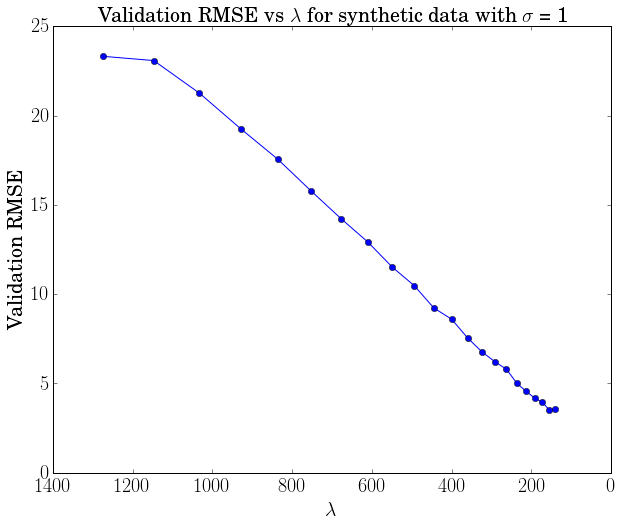

In [99]:
plt.plot(res[4],res[2],'-o')
plt.gca().invert_xaxis()
plt.xlabel(r"$\lambda$")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE vs $\lambda$ for synthetic data with $\sigma$ = 1")

print("Optimal lambda: %.2lf" % (res[3][-2]))

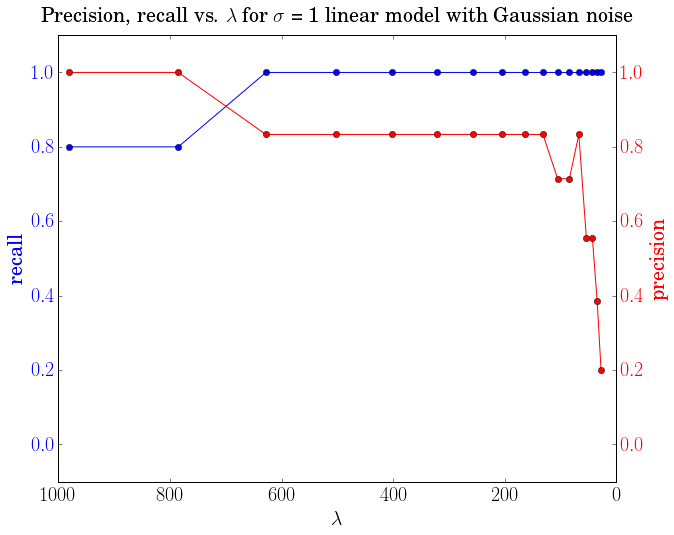

In [95]:
#Generate precsion, recall plots
fig, ax1 = plt.subplots()
ax1.plot(res[4],non_zeros/float(k), 'o-',color='b')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-.1,1.1)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('recall', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(res[4],non_zeros/tot_non_zeros, 'o-',color='r')
ax2.set_ylabel('precision', color='r')
ax2.set_ylim(-.1,1.1)
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.gca().invert_xaxis()
plt.title("Precision, recall vs. $\lambda$ for $\sigma$ = 1 linear model with Gaussian noise", y = 1.02)
plt.show()

# 6.3.1 Discussion
As can be seen above, the model was able to accurately recall the true number of non-zeros after only a few iterations which is rather impressive given the large initial $\lambda$.  As $\lambda$ decreases, the recall improves which makes sense since the non-zero weight values range between -10 and 10.  Also, the precision increases up until at point where it remains perfect. 

# Case: N = 50, d = 75, k = 5, $\sigma$ = 10

Lasso regression down a regularization path is performed on the linear data with Gaussian noise.  The precision and recall for the weight vector w is analyzed as a function of $\lambda$ in the plots below.

In [96]:
#Generate data set
N = 50
k = 5
d = 75
w, X, y = generate_norm_data(N,k,d,sigma=10)

l = compute_max_lambda(X,y)

N = y.shape[0]
d = X.shape[1]

#Run lasso regularization path 
#w_pred, w_0_pred, val_RMSE_list, train_RMSE_list, l_list, iter_list, nonzero_ind
res = lasso_reg_path(X,y,scale=0.9,reg_type="naive")

#Find true number of non-zeros
non_zeros = []
tot_non_zeros = []
k_mask = (w != 0)

for val in res[6]:
    #Compute total number of predicted non-zeros
    tot_non_zeros.append(np.sum(val))
    
    #Compute # of true non-zeros recovered
    mask_prime = np.logical_and(k_mask,val)
    non_zeros.append(np.sum(mask_prime))
        
non_zeros = np.asarray(non_zeros)
tot_non_zeros = np.asarray(tot_non_zeros)

Optimal lambda: 3.51


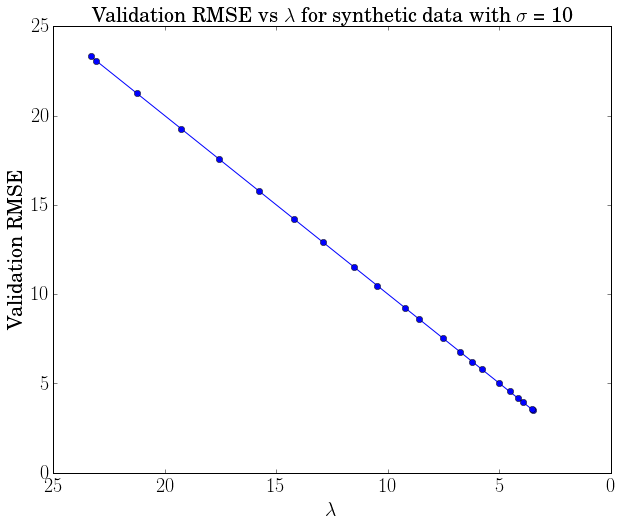

In [98]:
plt.plot(res[3],res[2],'-o')
plt.gca().invert_xaxis()
plt.xlabel(r"$\lambda$")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE vs $\lambda$ for synthetic data with $\sigma$ = 10")

print("Optimal lambda: %.2lf" % (res[3][-2]))

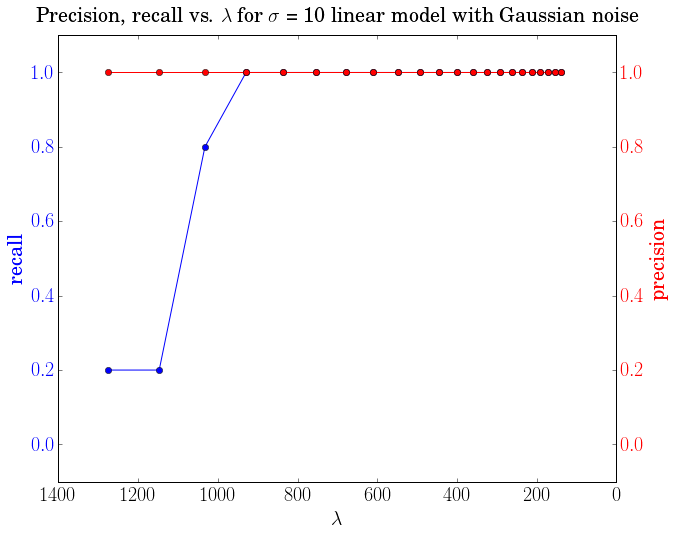

In [100]:
#Generate precision, recall plots
fig, ax1 = plt.subplots()
ax1.plot(res[4],non_zeros/float(k), 'o-',color='b')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-.1,1.1)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('recall', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(res[4],non_zeros/tot_non_zeros, 'o-',color='r')
ax2.set_ylabel('precision', color='r')
ax2.set_ylim(-.1,1.1)
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.gca().invert_xaxis()
plt.title("Precision, recall vs. $\lambda$ for $\sigma$ = 10 linear model with Gaussian noise", y = 1.02)
plt.show()

# 6.3.2 Discussion
As can be seen above, the model was able to accurately recall the true number of non-zeros after several iterations.  As $\lambda$ decreases, the recall improves which makes sense since the non-zero weight values range between -10 and 10 so the bounding value need not be too.  Also, the precision increases up until at point where it remains perfect until $\lambda$ gets quite small.  At this point, the precision decreases likely due to overfitting the noisy data.

With a larger $\sigma$, it takes many more iterations to reach a perfect recall and the precision decreases for low $\lambda$ due to overfitting.  This result makes sense since when fitting data with large variance, one would expect to have more trouble fitting the data as the underlying model is more obscured.  In order to achieve better precision and recall, one could set $\lambda$ to be proportional to $\sigma^2$ as this variance about the true model can provide reasonable limits for lasso regression to search over.

# 6.4 Become a data scientist at Yelp
We’ll now put the Lasso to work on some real data. Recently Yelp held a recruiting competition on the
analytics website Kaggle. Check it out at http://www.kaggle.com/c/yelp-recruiting. (As a side note,
browsing other competitions on the site may also give you some ideas for class projects.)

For this competition, the task is to predict the number of useful upvotes a particular review will receive. For
extra fun, we will add the additional task of predicting the review’s number of stars based on the review’s
text alone.

For many Kaggle competitions (and machine learning methods in general), one of the most important
requirements for doing well is the ability to discover great features. We can use our Lasso solver for this as
follows. First, generate a large amount of features from the data, even if many of them are likely unnecessary.
Afterward, use the Lasso to reduce the number of features to a more reasonable amount.

Yelp provides a variety of data, such as the review’s text, date, and restaurant, as well as data pertaining to
each business, user, and check-ins. This information has already been preprocessed for you into the following
files:
upvote data.csv Data matrix for predicting number of useful votes
upvote labels.txt List of useful vote counts for each review
upvote features.txt Names of each feature for interpreting results
star data.mtx Data matrix for predicting number of stars
star labels.txt List of number of stars given by each review
star features.txt Names of each feature
For each task, data files contain data matrices, while labels are stored in separate text files. The first data
matrix is stored in CSV format, each row corresponding to one review. The second data matrix is stored
in Matrix Market Format, a format for sparse matrices. Meta information for each feature is provided in
the final text files, one feature per line. For the upvote task, these are functions of various data attributes.
For the stars task, these are strings of one, two, or three words (n-grams). The feature values correspond
roughly to how often each word appears in the review. All columns have also been normalized.

# Load the Yelp Data

In [54]:
import scipy.io as io
import scipy.sparse as sparse
import os

os.chdir("/Users/dflemin3/Desktop/CSE_546/HW1/hw1-data")

# Load a text file of integers:
y = np.loadtxt("upvote_labels.txt", dtype=np.int)

# Load a text file of strings:
featureNames = open("upvote_features.txt").read().splitlines()

# Load a csv of floats:
A = np.genfromtxt("upvote_data.csv", delimiter=",")

# Load a matrix market matrix, convert it to csc format:
B = io.mmread("star_data.mtx").tocsc()

star_features = open("star_features.txt").read().splitlines()

star_y = np.loadtxt("star_labels.txt", dtype=np.int)

# Split the Upvote data into training, testing, and validation sets

In [18]:
#Put data into better format
A = sparse.csc_matrix(A)
y = y.reshape(len(y),1)

#Look at shape of data... 6000 x 1000
print A.shape
print y.shape

#Training
up_train_X = A[:4000,:]
up_train_y = y[:4000]

#Validation
up_val_X = A[4000:5000,:]
up_val_y = y[4000:5000]

#Testing
up_test_X = A[5000:,:]
up_test_y = y[5000:]

(6000, 1000)
(6000, 1)


# Starting at $\lambda_{max}$, run Lasso on the training set, decreasing $\lambda$ using previous solutions as initial conditions to each problem. 

Stop when you have considered enough λ’s that, based on validation error, you
can choose a good solution with confidence (for instance, when validation error begins increasing or
stops decreasing significant). At each solution, record the root-mean-squared-error (RMSE) on training
and validation data. In addition, record the number of nonzeros in each solution.

In [103]:
#Only run if I haven't before since it takes a long time
cwd = "/Users/dflemin3/Desktop/CSE_546/HW1/"

if (not os.path.exists(cwd+"yelp_up_archive.npz")):
    res = lasso_reg_path(up_train_X,up_train_y,scale=0.8,X_val=up_val_X,y_val=up_val_y)
    up_res = res
    #Archive result
    np.savez(cwd+"yelp_up_archive.npz",res=res)
else:
    archive = np.load(cwd+"yelp_up_archive.npz")
    up_res = archive['res']

# Questions 6.1, 6.2

Optimal lambda: 1.99


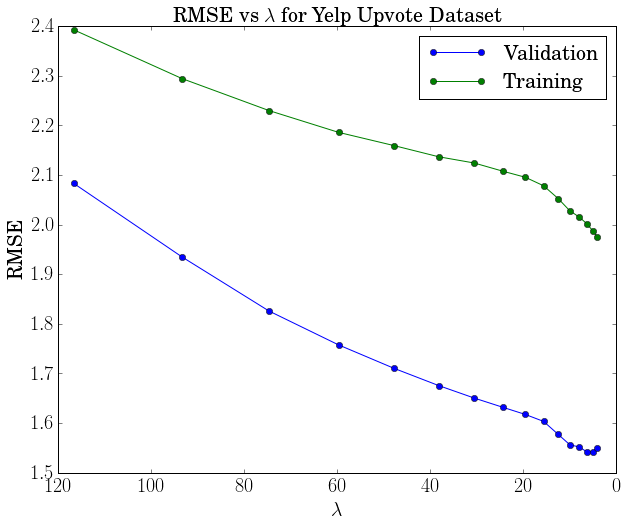

In [109]:
#w_pred, w_0_pred, val_RMSE_list, train_RMSE_list, l_list, iter_list, nonzero_ind

plt.plot(up_res[4],up_res[2],'-o',label='Validation')
plt.plot(up_res[4],up_res[3],'-o',label='Training')
plt.gca().invert_xaxis()
plt.xlabel(r"$\lambda$")
plt.ylabel("RMSE")
plt.title("RMSE vs $\lambda$ for Yelp Upvote Dataset")
plt.legend()

print("Optimal lambda: %.2lf" % (up_res[3][-2]))

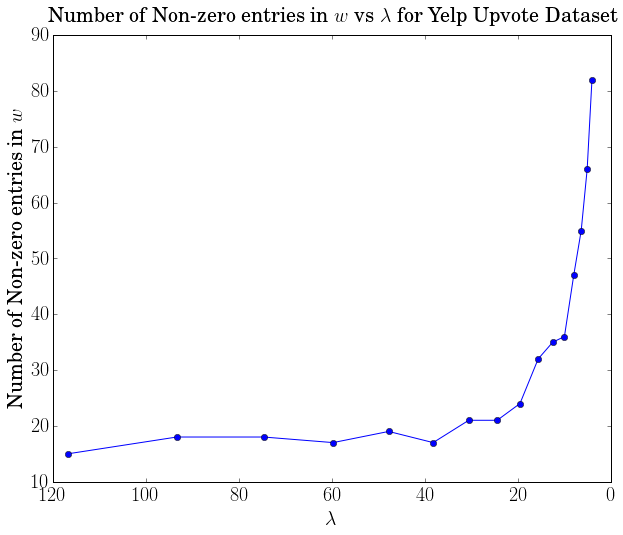

In [111]:
#res contains w_pred, w_0_pred, MSE_list, l_list, iter_list, nonzero_ind

#Find true number of non-zeros
non_zeros = []

for val in up_res[6]:
    #Compute total number of predicted non-zeros
    non_zeros.append(np.sum(val))

plt.plot(up_res[4],non_zeros,'-o')
plt.gca().invert_xaxis()
plt.xlabel(r"$\lambda$")
plt.ylabel(r"Number of Non-zero entries in $w$")
plt.title(r"Number of Non-zero entries in $w$ vs $\lambda$ for Yelp Upvote Dataset",y=1.02)

In [106]:
ind_list = np.where(np.fabs(res[0]) > 0)[1]
for ind in ind_list:
    print featureNames[ind]

log(ReviewNumLineBreaks*BusinessNumReviews)
ReviewNumSmileys*InPhoenix
log(ReviewInSpring*BusinessNumStars)
UserUsefulVotes*InScottsdale
sqrt(UserFunnyVotes*InPhoenix)
log(UserFunnyVotes*BusinessNumReviews)
ReviewNumCharacters*ReviewNumLineBreaks
UserUsefulVotes*IsBeautyAndSpas
sqrt(ReviewDate)
sq(UserUsefulVotes*InScottsdale)
sq(ReviewDate*UserUsefulVotes)
log(ReviewNumLineBreaks*BusinessNumStars)
ReviewNumCharacters*BusinessLongitude
log(BusinessNumStars)
sqrt(ReviewNumCharacters*UserFunnyVotes)
log(ReviewNumLineBreaks*UserCoolVotes)
log(UserAverageStars*BusinessNumStars)
indicator(UserAverageStars*BusinessNumStars)
sqrt(UserFunnyVotes*BusinessNumStars)
UserFunnyVotes*IsShopping
indicator(UserUsefulVotes*BusinessNumReviews)
log(IsActiveLife*BusinessNumCheckins)
ReviewNumLineBreaks*InPhoenix
sq(ReviewDate*BusinessLatitude)
sqrt(UserCoolVotes*BusinessNumStars)
sq(UserUsefulVotes*IsRestaurant)
sqrt(ReviewNumLineBreaks*UserCoolVotes)
log(BusinessLongitude*BusinessNumCheckins)
BusinessNum

In [55]:
#Put data into better format
B = sparse.csc_matrix(B)
star_y = star_y.reshape(len(star_y),1) # 45000 x 1

#Look at shape of data... 45000 x 2500
print B.shape
print star_y.shape

#Training
star_train_X = B[:30000,:]
star_train_y = star_y[:30000]

#Validation
star_val_X = B[30000:37500,:]
star_val_y = star_y[30000:37500]

#Testing
star_test_X = B[37500:,:]
star_test_y = star_y[37500:]

(45000, 2500)
(45000, 1)


In [68]:
#Only run if I haven't before since it takes a long time
cwd = "/Users/dflemin3/Desktop/CSE_546/HW1/"

if (not os.path.exists(cwd+"yelp_star_archive.npz")):
    res = lasso_reg_path(star_train_X,star_train_y,scale=0.5,X_val=star_val_X,y_val=star_val_y)
    
    #Archive result
    np.savez(cwd+"yelp_star_archive.npz",res=res)
else:
    archive = np.load(cwd+"yelp_star_archive.npz")
    res = archive['res']

In [69]:
print np.sum(res[0] != 0)

931
